In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from langdetect import detect
import spacy
from sklearn.metrics import roc_curve, auc

In [2]:
# Load dataset

data = pd.read_csv('r_news_top_jan_to_may_2021.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

Post ID                                              Title  \
0  lr3xap  Man dies after police kneel on his neck for ne...   
1  lsmh36  Texan files $1 billion class-action lawsuit af...   
2  ls7xmj  Trump tax returns are now in the hands of the ...   
3  laun1r  Minneapolis police officers must keep body cam...   
4  lsbgop  Costco lifts minimum wage above Amazon or Targ...   

                                                 Url        Author   Score  \
0  https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...  monaleeparis  100226   
1  https://abcnews.go.com/US/texan-files-billion-...   ACABBLM2020   97551   
2  https://www.cnbc.com/2021/02/25/trump-tax-retu...     [deleted]   98318   
3  https://www.cnn.com/2021/02/02/us/minneapolis-...       dlkapt3  103302   
4  https://www.reuters.com/article/us-costco-whol...  candordirect   99299   

          Publish Date  Total No. of Comments  \
0  2021-02-23 20:43:30                  17754   
1  2021-02-25 17:30:11                  14574   
2  2021-02-25 06:38:18                  12719   
3  2021-02-02 04:42:35                   7312   
4  2021-02-25 09:11:08                   8124   

                                           Permalink Flair  duplicate  \
0  /r/news/comments/lr3xap/man_dies_after_police_...   NaN      False   
1  /r/news/comments/lsmh36/texan_files_1_billion_...   NaN      False   
2  /r/news/comments/ls7xmj/trump_tax_returns_are_...   NaN       True   
3  /r/news/comments/laun1r/minneapolis_police_off...   NaN      False   
4  /r/news/comments/lsbgop/costco_lifts_minimum_w...   NaN      False   

   Engagement  
0      117980  
1      112125  
2      111037  
3      110614  
4      107423

In [3]:
# Basic stats and info
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11240 entries, 0 to 11239
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Post ID                11240 non-null  object
 1   Title                  11240 non-null  object
 2   Url                    11240 non-null  object
 3   Author                 11240 non-null  object
 4   Score                  11240 non-null  int64 
 5   Publish Date           11240 non-null  object
 6   Total No. of Comments  11240 non-null  int64 
 7   Permalink              11240 non-null  object
 8   Flair                  1406 non-null   object
 9   duplicate              11240 non-null  bool  
 10  Engagement             11240 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 889.2+ KB


Score  Total No. of Comments     Engagement
count   11240.000000           11240.000000   11240.000000
mean      348.642527             315.755249     664.397776
std      3859.455582            1137.370254    4369.823990
min         0.000000               0.000000      10.000000
25%         1.000000              16.000000      21.000000
50%         1.000000              40.000000      52.000000
75%         6.250000             154.000000     192.000000
max    103302.000000           41107.000000  117980.000000

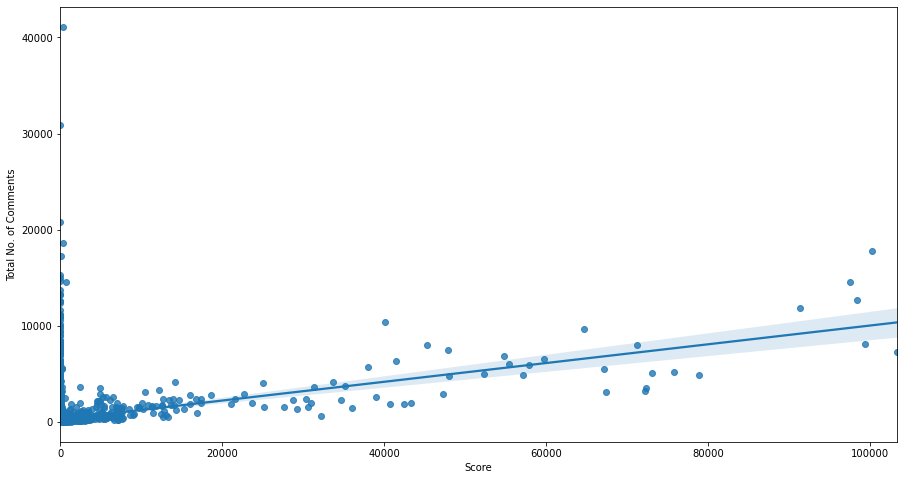

In [4]:
# Check relationship between Score and # Comments
plt.figure(figsize=(15,8))
sns.regplot(x=data.Score, y=data['Total No. of Comments'])

plt.show()

There are clear outliers in both directions, and a pretty weak positive relationship. Engagement doesn't seem to be useful in aggregate, but is good to set the cutoff for our data set. 

# Headline Information

# Words

In [5]:
# Create column of word lists and word counts
# Correct case of column and eliminate special characters

data['title_case_correct'] = data['Title'].str.lower()
data['title_case_correct'] = data['title_case_correct'].astype(str).replace('[^a-zA-Z0-9 ]','',regex=True)
data['title_words'] = data['title_case_correct'].str.split()

In [6]:
# One more col minus stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['title_words'] = data['title_words'].apply(lambda x: [item for item in x if item not in stop])

In [7]:
# Drop rows that are in other languages
data['language'] = data['title_case_correct'].apply(detect)
data = data[data['language'] == 'en']

In [8]:
# Lemmatize title and words

nlp = spacy.load('en_core_web_sm')

In [9]:
data['lemmatized'] = data['title_case_correct']

In [10]:
data['lemmatized'] = data['lemmatized'].apply(lambda row: " ".join(w.lemma_ for w in nlp(row)))

In [11]:
data['lemmatized_words'] = data['lemmatized'].str.split()

In [12]:
data['lemmatized_words'] = data['lemmatized_words'].apply(lambda x: [item for item in x if item not in stop])

In [13]:
# Add Percentile to the headlines

data['score_percentile'] = data.Score.rank(pct=True)
data['comments_percentile'] = data['Total No. of Comments'].rank(pct=True)
data['engagement_percentile'] = data.Engagement.rank(pct=True)

In [14]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50)
bands = [(data['score_percentile'] >= .95), (data['score_percentile'] < .95) & (data['score_percentile'] > .5), (data['score_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['score_band'] = np.select(bands, values)

In [15]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50) for comments now
bands = [(data['comments_percentile'] >= .95), (data['comments_percentile'] < .95) & (data['comments_percentile'] > .5), (data['comments_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['comm_band'] = np.select(bands, values)

In [16]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50) for comments now
bands = [(data['engagement_percentile'] >= .95), (data['engagement_percentile'] < .95) & (data['engagement_percentile'] > .5), (data['engagement_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['eng_band'] = np.select(bands, values)

In [17]:
# Make data sets for each band
data_score_5 = data[data['score_band'] == 'Top 5']
data_score_45 = data[data['score_band'] == 'Middle 45']
data_score_50 = data[data['score_band'] == 'Bottom 50']
data_comm_5 = data[data['comm_band'] == 'Top 5']
data_comm_45 = data[data['comm_band'] == 'Middle 45']
data_comm_50 = data[data['comm_band'] == 'Bottom 50']
data_eng_5 = data[data['eng_band'] == 'Top 5']
data_eng_45 = data[data['eng_band'] == 'Middle 45']
data_eng_50 = data[data['eng_band'] == 'Bottom 50']

In [18]:
def df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

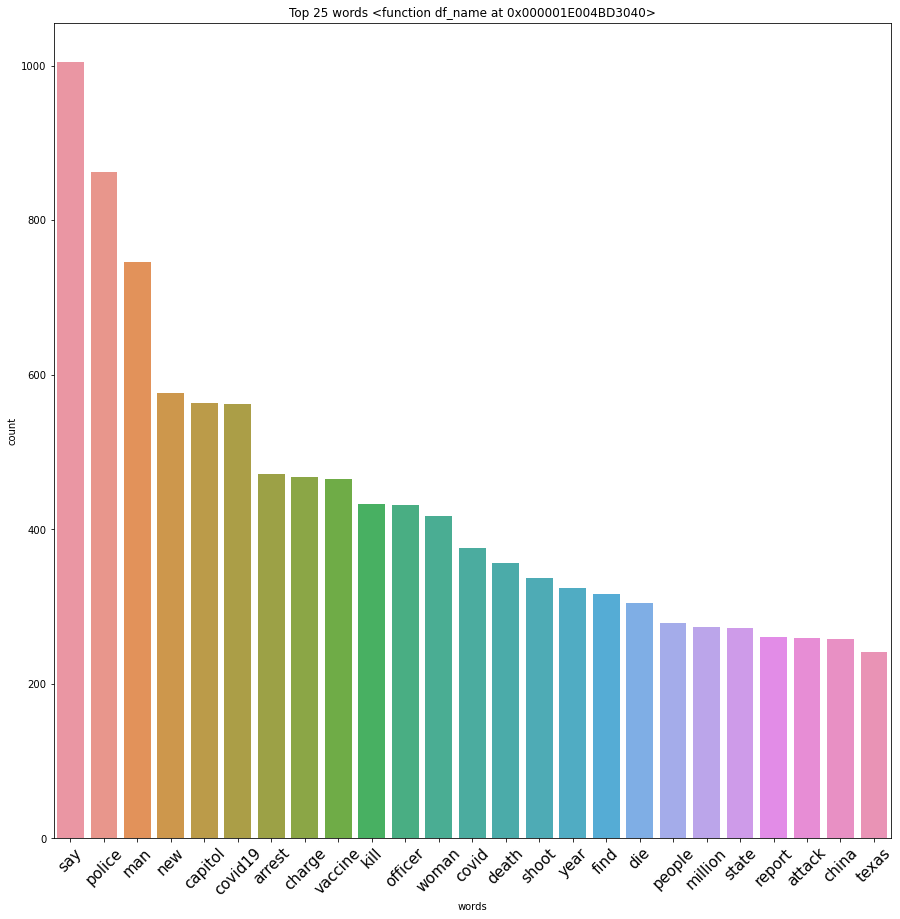

In [19]:
# Count and plot of most frequent words

words = data['lemmatized_words'].explode()
words_df = pd.DataFrame(words.value_counts())
words_df = words_df.reset_index()
words_df.columns = ['words','count']
top_25_words = words_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

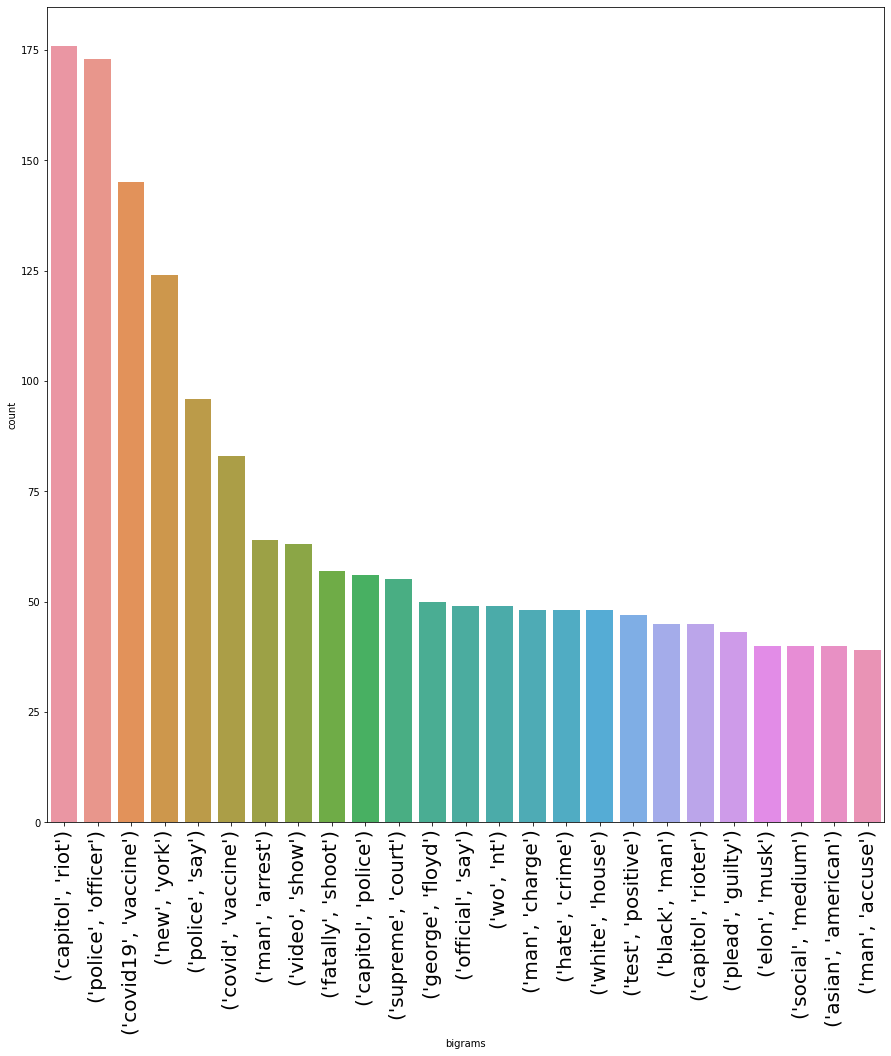

In [20]:
bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
bigrams_df = pd.DataFrame(bigrams)
bigrams_df = bigrams_df.reset_index()
bigrams_df.columns = ['bigrams','count']
top_25_bigrams = bigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

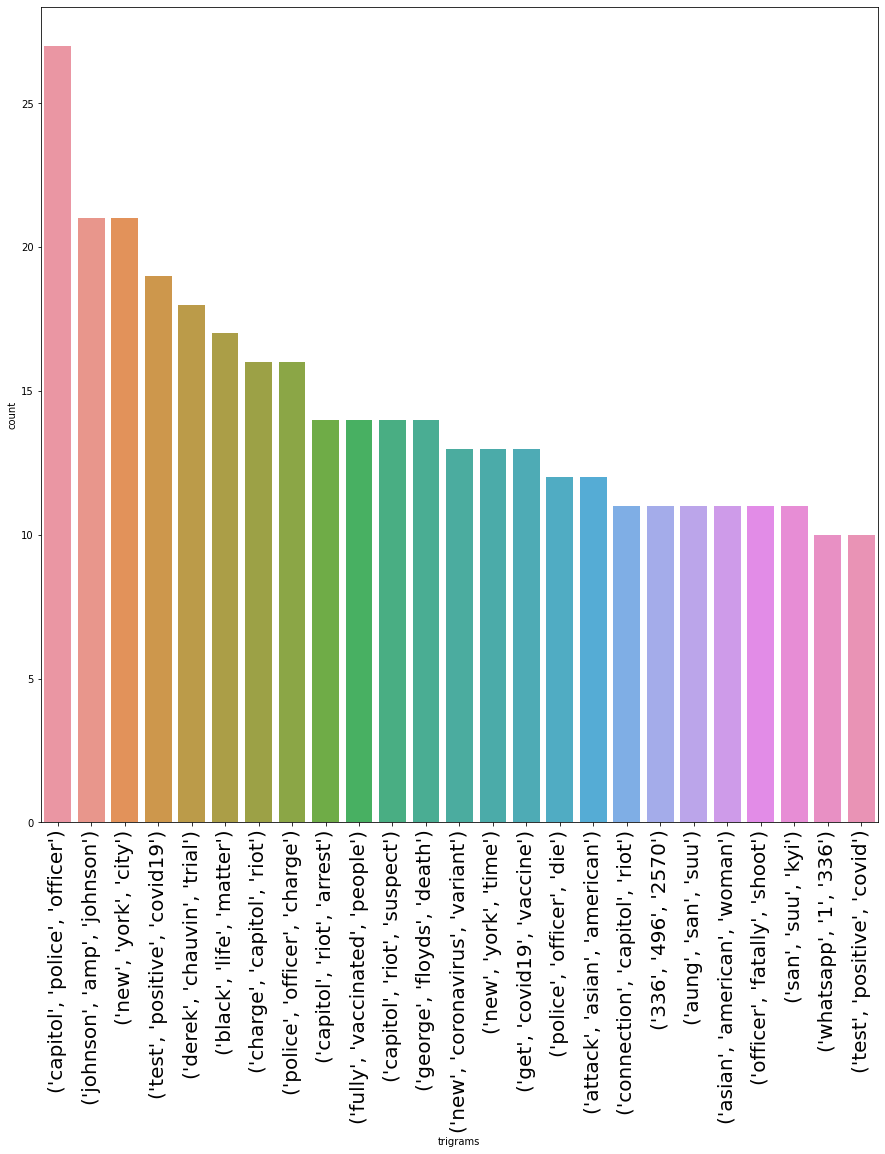

In [21]:
trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
trigrams_df = pd.DataFrame(trigrams)
trigrams_df = trigrams_df.reset_index()
trigrams_df.columns = ['trigrams','count']
top_25_trigrams = trigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

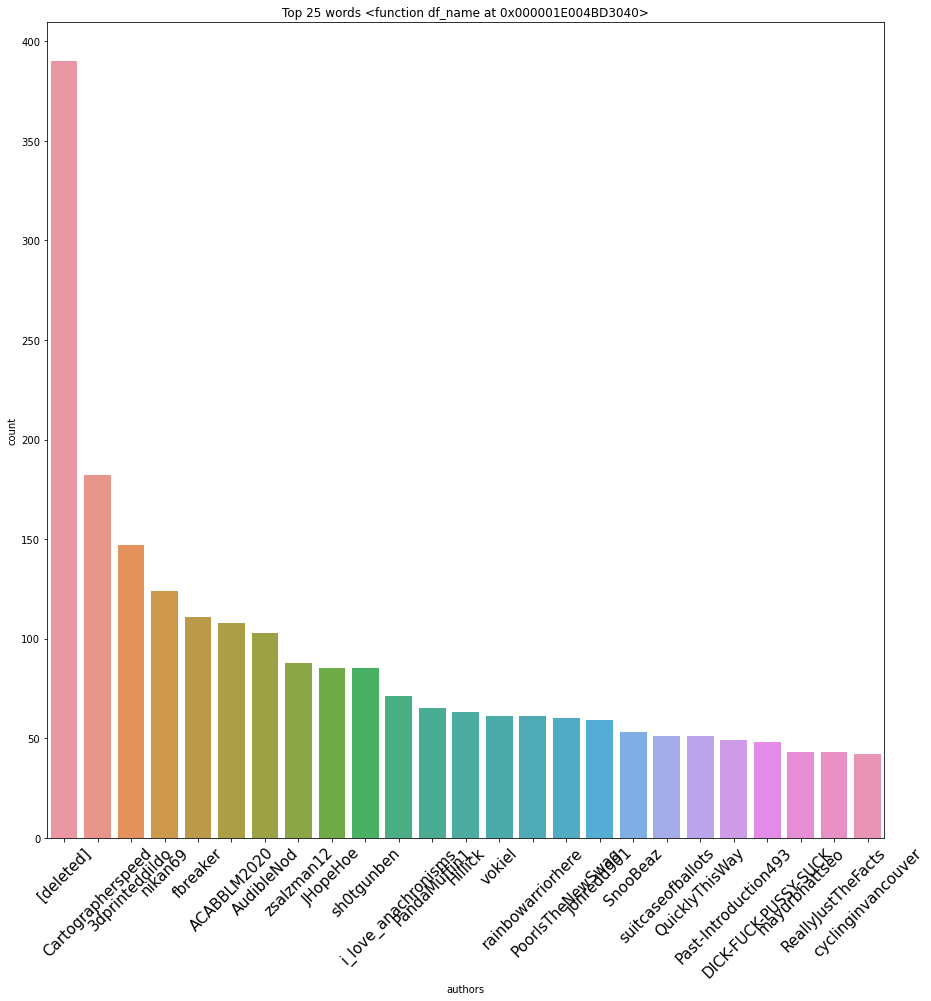

In [22]:

authors_df = pd.DataFrame(data['Author'].value_counts())
authors_df = authors_df.reset_index()
authors_df.columns = ['authors','count']
top_25_authors = authors_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

In [23]:
authors_df = pd.DataFrame(data['Author'].value_counts())
authors_df = authors_df.reset_index()
authors_df.columns = ['authors','count']

authors_df

authors  count
0             [deleted]    390
1     Cartographerspeed    182
2        3dprinteddildo    147
3               nikan69    124
4              fbreaker    111
...                 ...    ...
3888        dogslovers1      1
3889     butmuhfreedoms      1
3890      little-bird89      1
3891    notickeynoworky      1
3892    Idontknowwhour1      1

[3893 rows x 2 columns]

<AxesSubplot:xlabel='score_band', ylabel='Score'>

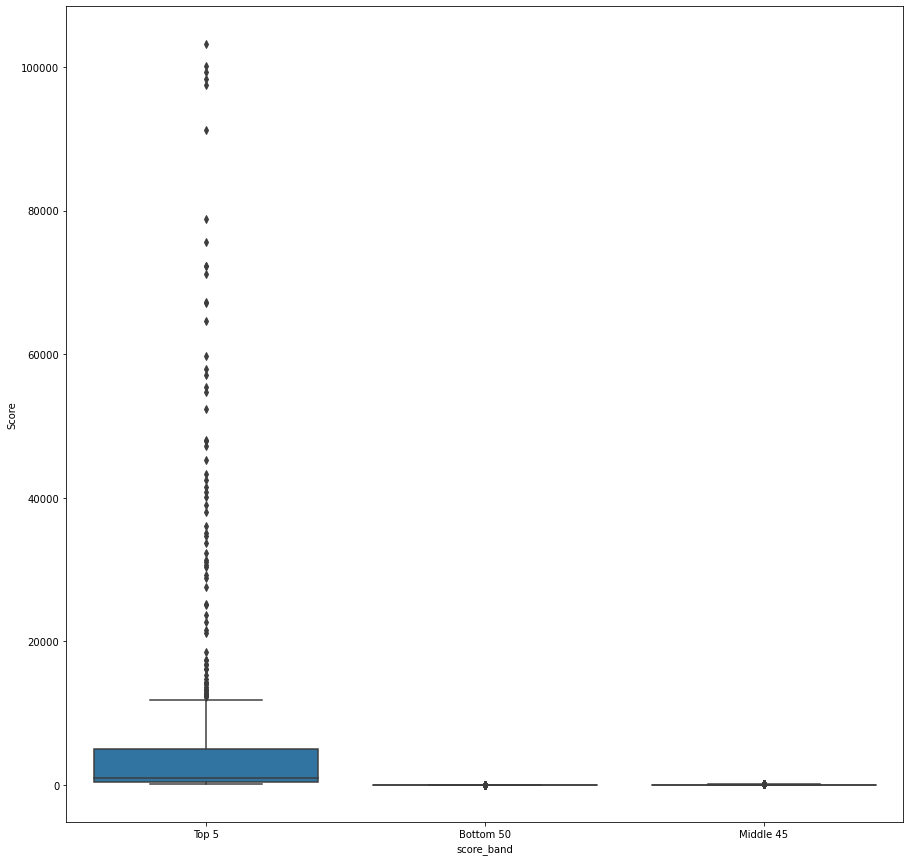

In [24]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Score'], x=data['score_band'], y=data['Score'])

<AxesSubplot:xlabel='comm_band', ylabel='Total No. of Comments'>

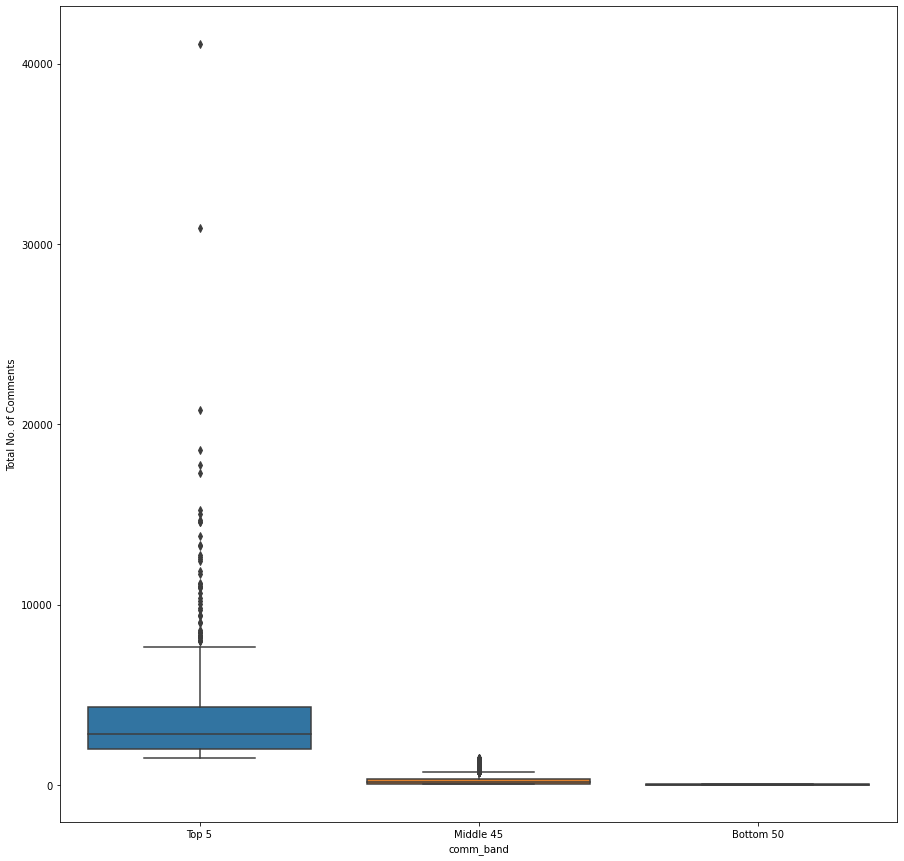

In [25]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Total No. of Comments'], x=data['comm_band'], y=data['Total No. of Comments'])

<AxesSubplot:xlabel='eng_band', ylabel='Engagement'>

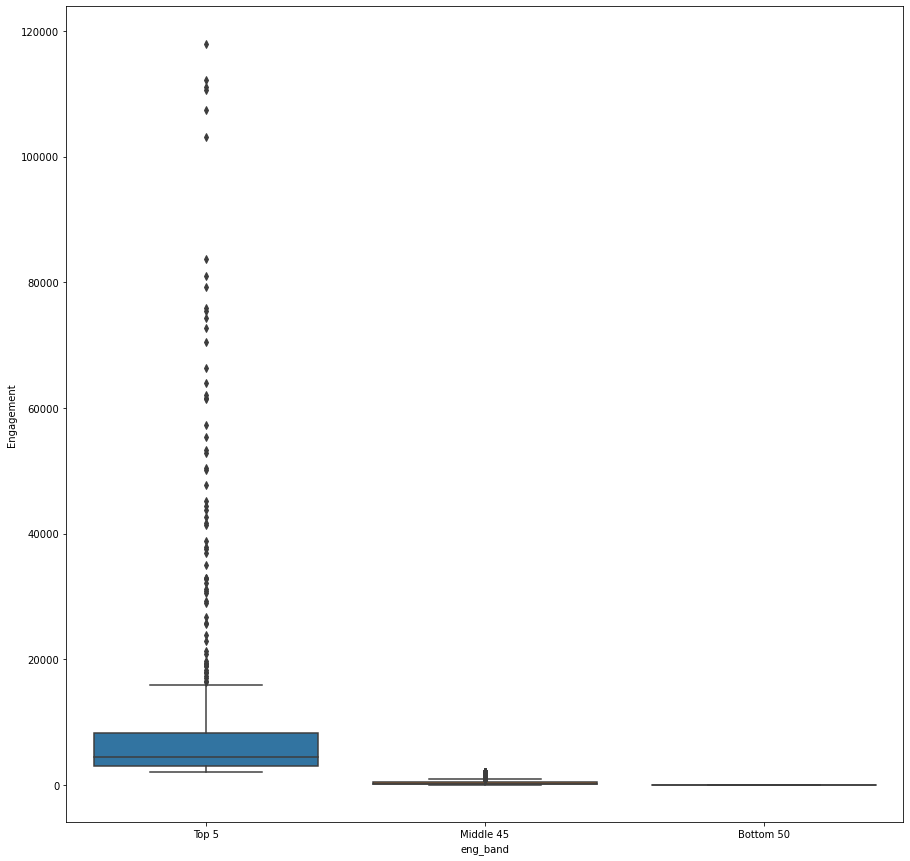

In [26]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Engagement'], x=data['eng_band'], y=data['Engagement'])

In [27]:
# Colossal gap beteen top story's score and bottom story's, even within the band
# Consider a 1%/49%/50% split

data[data['score_band']=='Top 5'].describe()

Score  Total No. of Comments     Engagement  score_percentile  \
count     542.000000             542.000000     542.000000        542.000000   
mean     6882.979705            1056.985240    7939.964945          0.975058   
std     15949.881364            2684.627081   17619.830256          0.014440   
min       185.000000               6.000000     202.000000          0.950161   
25%       337.750000             104.500000     518.250000          0.962563   
50%       935.500000             297.500000    1407.500000          0.975058   
75%      4937.750000             860.500000    6046.750000          0.987529   
max    103302.000000           41107.000000  117980.000000          1.000000   

       comments_percentile  engagement_percentile  
count           542.000000             542.000000  
mean              0.782019               0.917605  
std               0.182728               0.068305  
min               0.053204               0.757077  
25%               0.693476               0.863912  
50%               0.830037               0.931996  
75%               0.922165               0.982550  
max               1.000000               1.000000

In [28]:
# Not a dramatic of a gap, but still very high

data[data['comm_band']=='Top 5'].describe()

Score  Total No. of Comments     Engagement  score_percentile  \
count     543.000000             543.000000     543.000000        543.000000   
mean     5224.572744            3863.709024    9088.281768          0.553424   
std     16117.757972            3458.265502   17101.770108          0.280926   
min         1.000000            1475.000000    1476.000000          0.331950   
25%         1.000000            1967.500000    2164.000000          0.331950   
50%         1.000000            2792.000000    3350.000000          0.331950   
75%        29.000000            4330.500000    6621.000000          0.873767   
max    103302.000000           41107.000000  117980.000000          1.000000   

       comments_percentile  engagement_percentile  
count           543.000000             543.000000  
mean              0.975012               0.967269  
std               0.014467               0.019166  
min               0.950023               0.934578  
25%               0.962517               0.950991  
50%               0.975012               0.966621  
75%               0.987506               0.984048  
max               1.000000               1.000000

In [29]:
# Not a dramatic of a gap, but still very high

data[data['eng_band']=='Top 5'].describe()

Score  Total No. of Comments     Engagement  score_percentile  \
count     543.000000             543.000000     543.000000        543.000000   
mean     6547.454880            3604.042357   10151.497238          0.674357   
std     16064.927572            3647.043458   16949.980171          0.309034   
min         1.000000              69.000000    2122.000000          0.331950   
25%         1.000000            1587.500000    2995.000000          0.331950   
50%         6.000000            2792.000000    4386.000000          0.743384   
75%      4922.500000            4330.500000    8210.500000          0.987506   
max    103302.000000           41107.000000  117980.000000          1.000000   

       comments_percentile  engagement_percentile  
count           543.000000             543.000000  
mean              0.956454               0.975012  
std               0.053277               0.014467  
min               0.618119               0.950023  
25%               0.953942               0.962517  
50%               0.975012               0.975012  
75%               0.987506               0.987506  
max               1.000000               1.000000

In [30]:
data_analysis = data_eng_5.append(data_eng_50, ignore_index=True)
data_analysis['eng_band'] = data_analysis['eng_band'].replace({'Top 5':1, 'Bottom 50':0})
data_analysis

Post ID                                              Title  \
0     lr3xap  Man dies after police kneel on his neck for ne...   
1     lsmh36  Texan files $1 billion class-action lawsuit af...   
2     ls7xmj  Trump tax returns are now in the hands of the ...   
3     laun1r  Minneapolis police officers must keep body cam...   
4     lsbgop  Costco lifts minimum wage above Amazon or Targ...   
...      ...                                                ...   
5935  mxf36e  Bones of Black children killed in police bombi...   
5936  mjb8qw  A juvenile has been arrested following a video...   
5937  n3oquf  (Australia) 80yo fisher finds himself trapped ...   
5938  n545c8  Minorities underrepresented in vaccinated popu...   
5939  n6l1ue      Canada Fines passengers with Fake Covid Tests   

                                                    Url                Author  \
0     https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...          monaleeparis   
1     https://abcnews.go.com/US/texan-files-billion-...           ACABBLM2020   
2     https://www.cnbc.com/2021/02/25/trump-tax-retu...             [deleted]   
3     https://www.cnn.com/2021/02/02/us/minneapolis-...               dlkapt3   
4     https://www.reuters.com/article/us-costco-whol...          candordirect   
...                                                 ...                   ...   
5935  https://www.theguardian.com/us-news/2021/apr/2...                mod_89   
5936  https://www.cnn.com/2021/04/03/us/asian-couple...   Piranha_ChuckNorris   
5937  https://www.abc.net.au/news/2021-05-03/fisherm...             LuckyBdx4   
5938  https://www.kxly.com/minorities-underrepresent...            MasterRazz   
5939  https://globalnews.ca/news/7838978/canada-covi...  GambleEvrything4Love   

       Score         Publish Date  Total No. of Comments  \
0     100226  2021-02-23 20:43:30                  17754   
1      97551  2021-02-25 17:30:11                  14574   
2      98318  2021-02-25 06:38:18                  12719   
3     103302  2021-02-02 04:42:35                   7312   
4      99299  2021-02-25 09:11:08                   8124   
...      ...                  ...                    ...   
5935       1  2021-04-24 00:35:28                      9   
5936       5  2021-04-03 08:57:30                      5   
5937       1  2021-05-02 22:29:06                      9   
5938       1  2021-05-04 18:40:19                      9   
5939       1  2021-05-06 16:39:09                      9   

                                              Permalink Flair  duplicate  ...  \
0     /r/news/comments/lr3xap/man_dies_after_police_...   NaN      False  ...   
1     /r/news/comments/lsmh36/texan_files_1_billion_...   NaN      False  ...   
2     /r/news/comments/ls7xmj/trump_tax_returns_are_...   NaN       True  ...   
3     /r/news/comments/laun1r/minneapolis_police_off...   NaN      False  ...   
4     /r/news/comments/lsbgop/costco_lifts_minimum_w...   NaN      False  ...   
...                                                 ...   ...        ...  ...   
5935  /r/news/comments/mxf36e/bones_of_black_childre...   NaN      False  ...   
5936  /r/news/comments/mjb8qw/a_juvenile_has_been_ar...   NaN      False  ...   
5937  /r/news/comments/n3oquf/australia_80yo_fisher_...   NaN      False  ...   
5938  /r/news/comments/n545c8/minorities_underrepres...   NaN      False  ...   
5939  /r/news/comments/n6l1ue/canada_fines_passenger...   NaN      False  ...   

                                            title_words language  \
0     [man, dies, police, kneel, neck, nearly, 5, mi...       en   
1     [texan, files, 1, billion, classaction, lawsui...       en   
2     [trump, tax, returns, hands, manhattan, distri...       en   
3     [minneapolis, police, officers, must, keep, bo...       en   
4     [costco, lifts, minimum, wage, amazon, target,...       en   
...                                                 ...      ...   
5935  [bones, black, children, killed, police, bombi...  

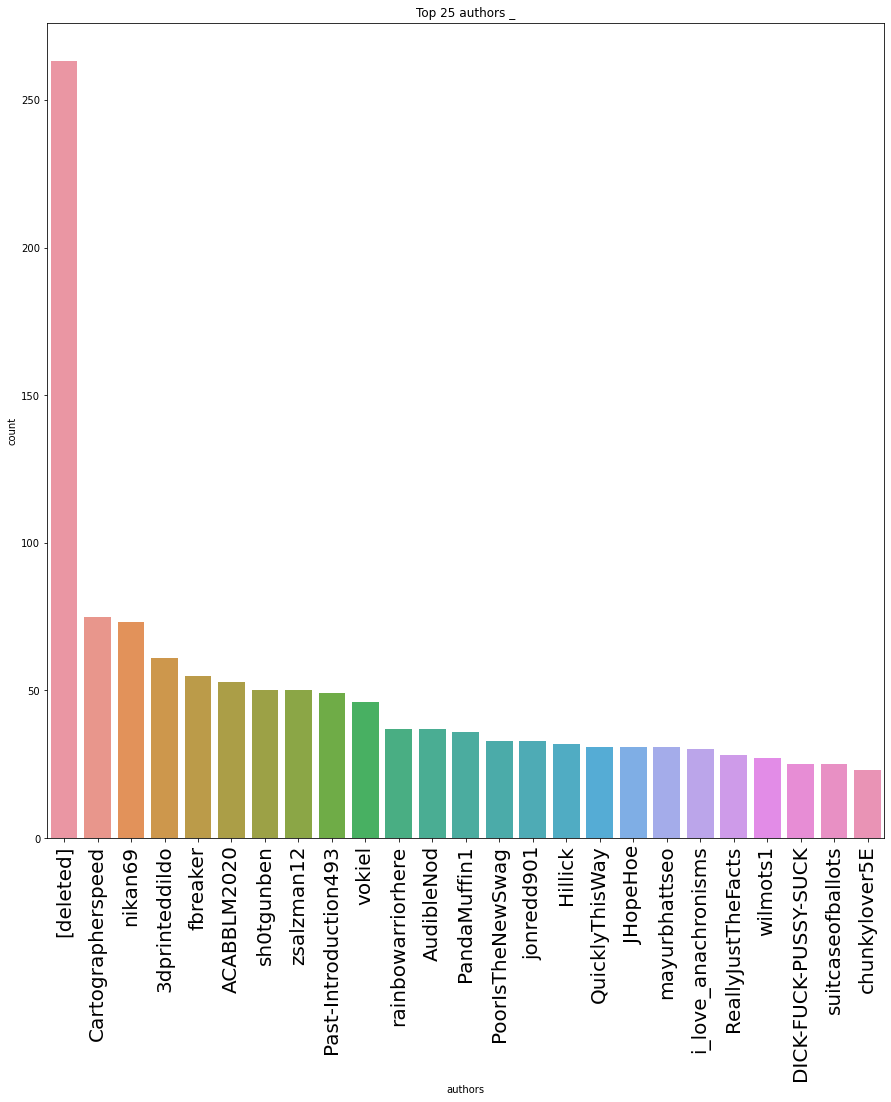

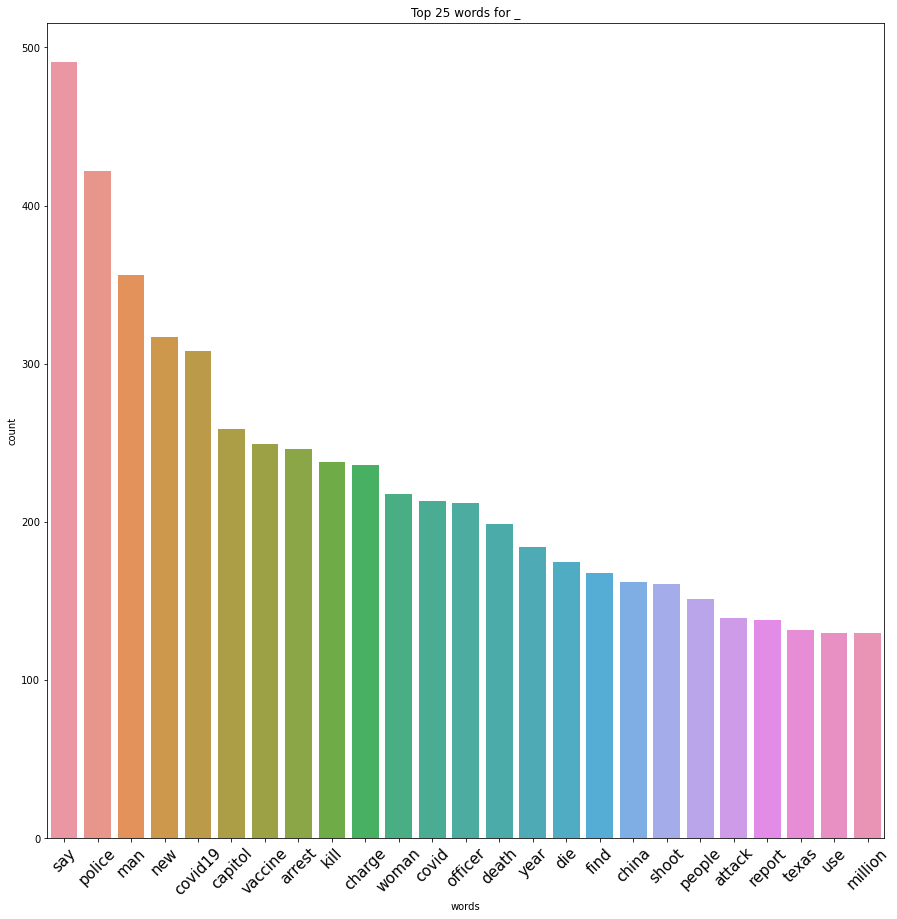

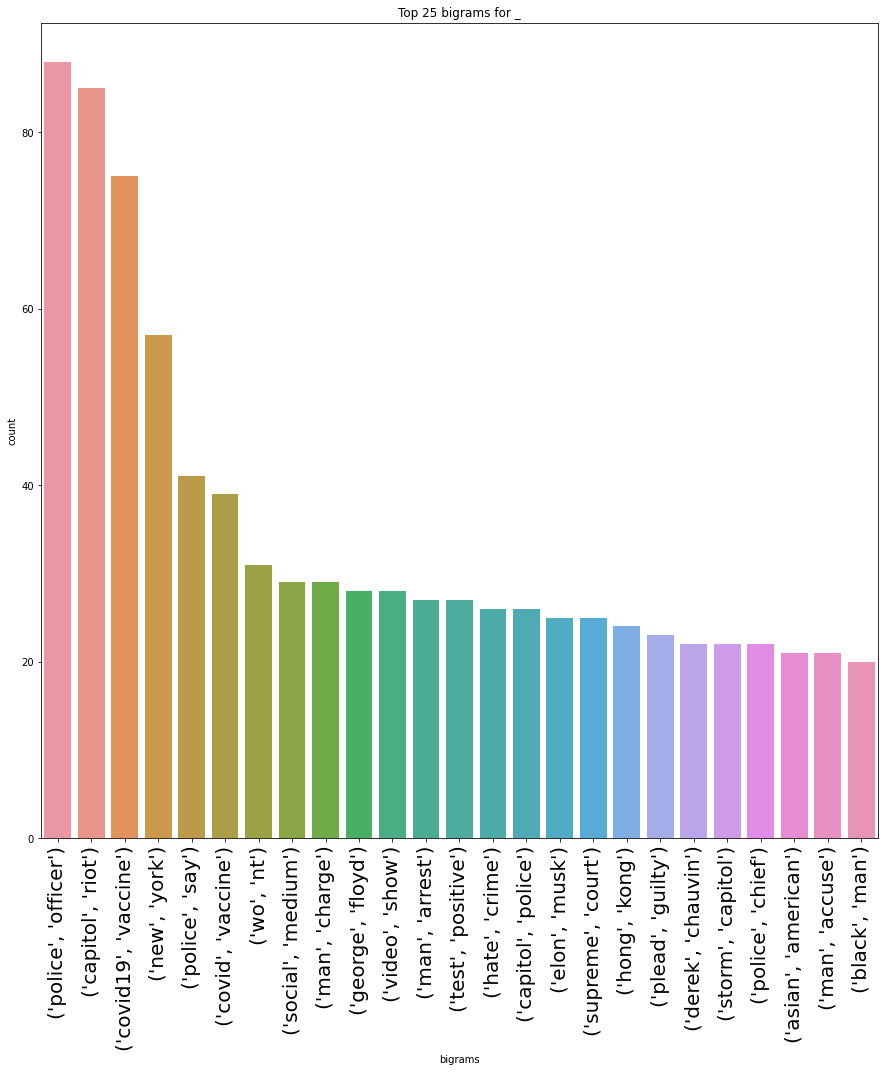

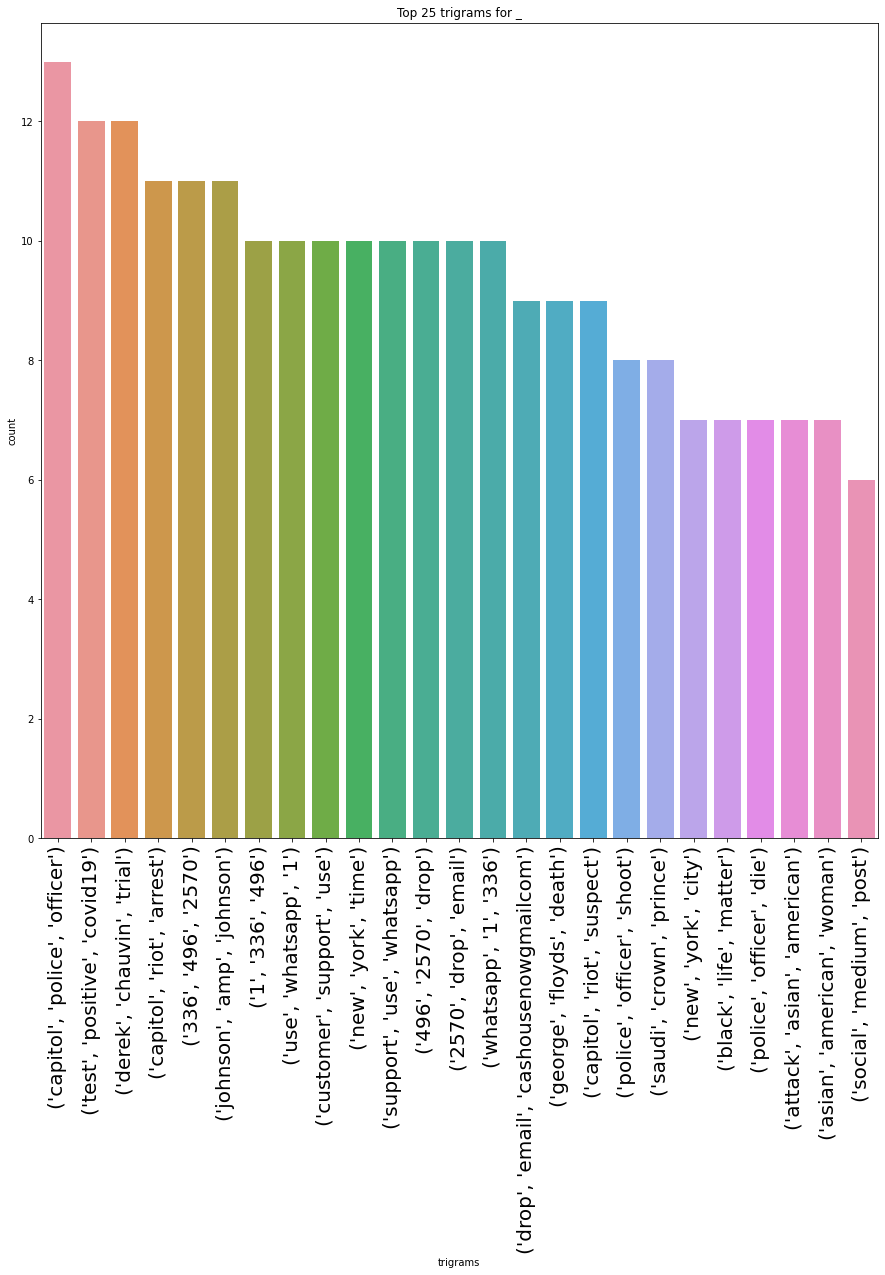

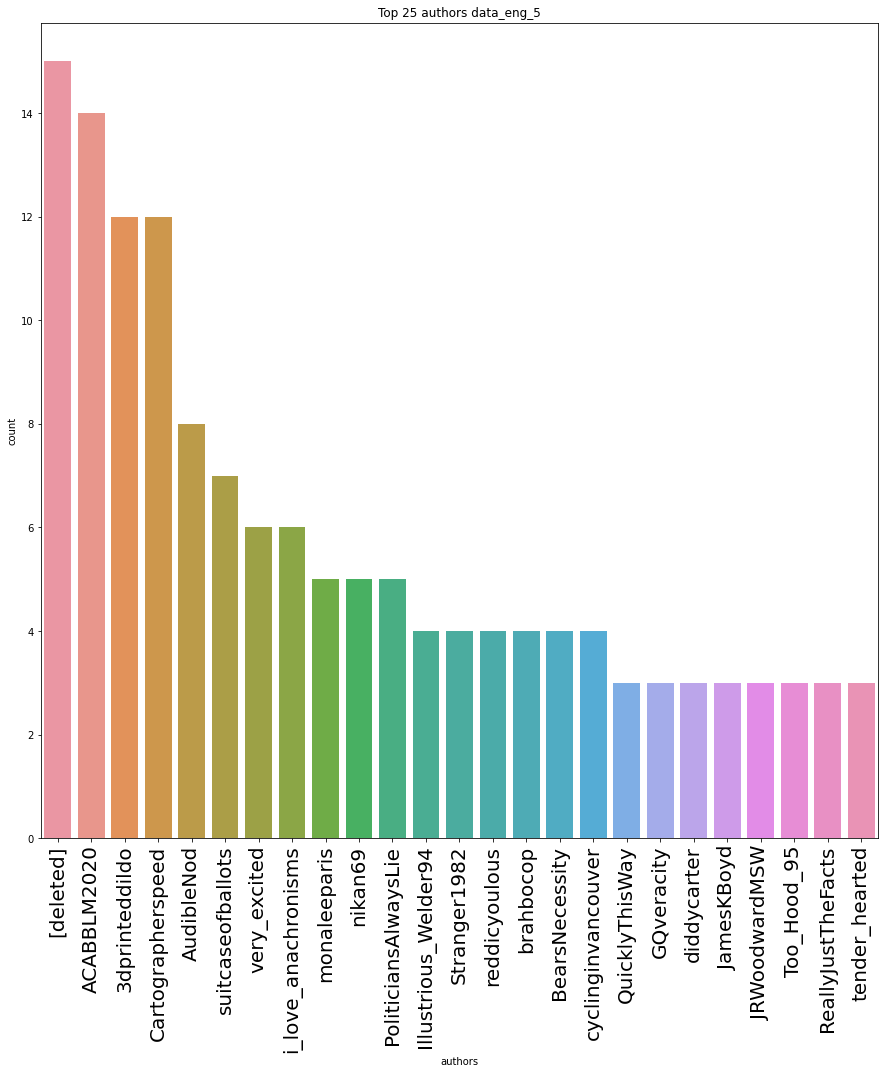

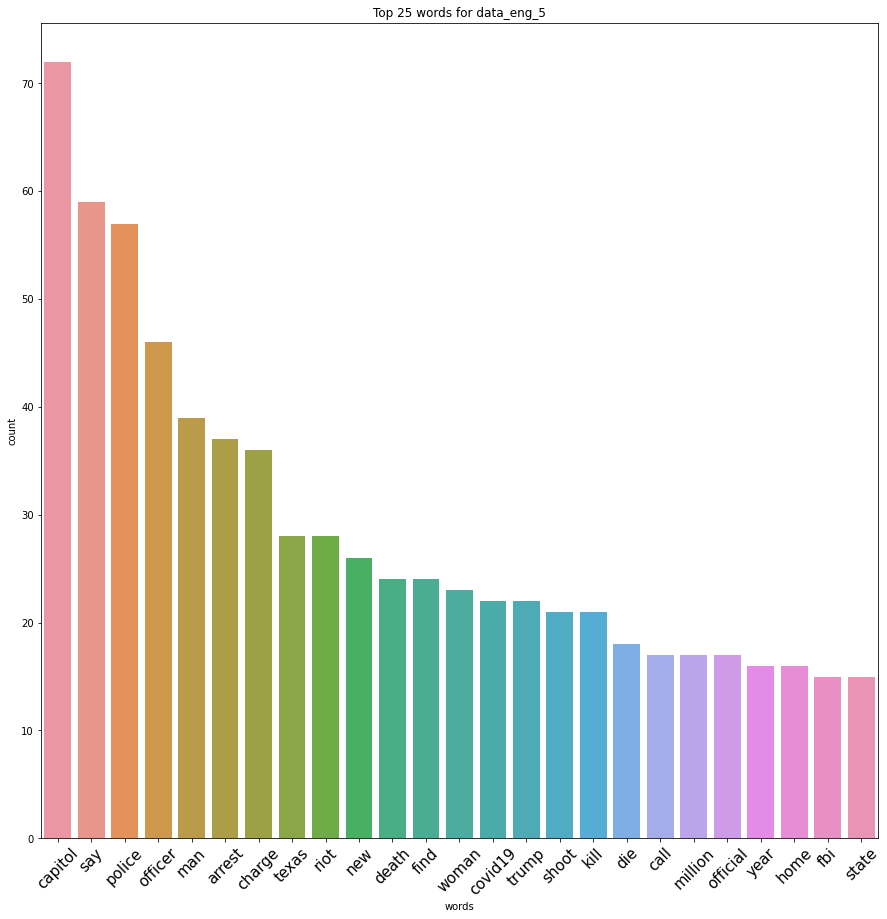

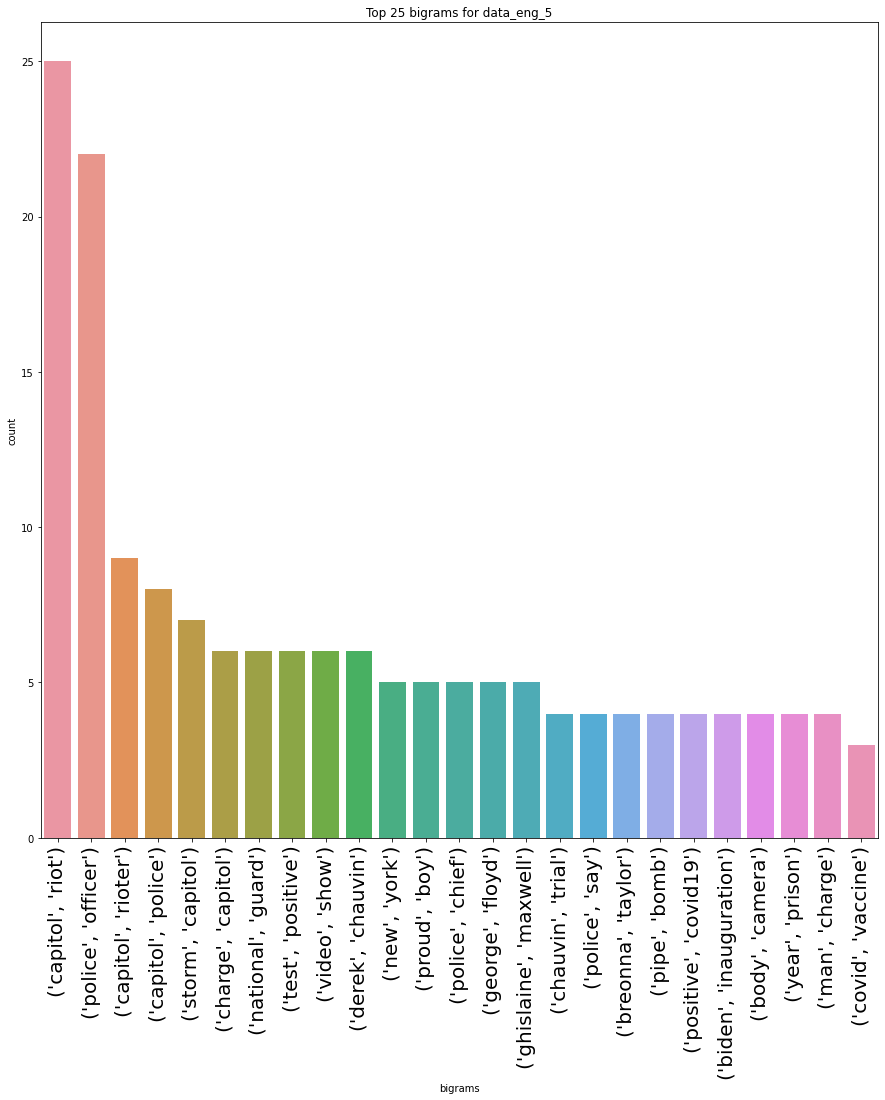

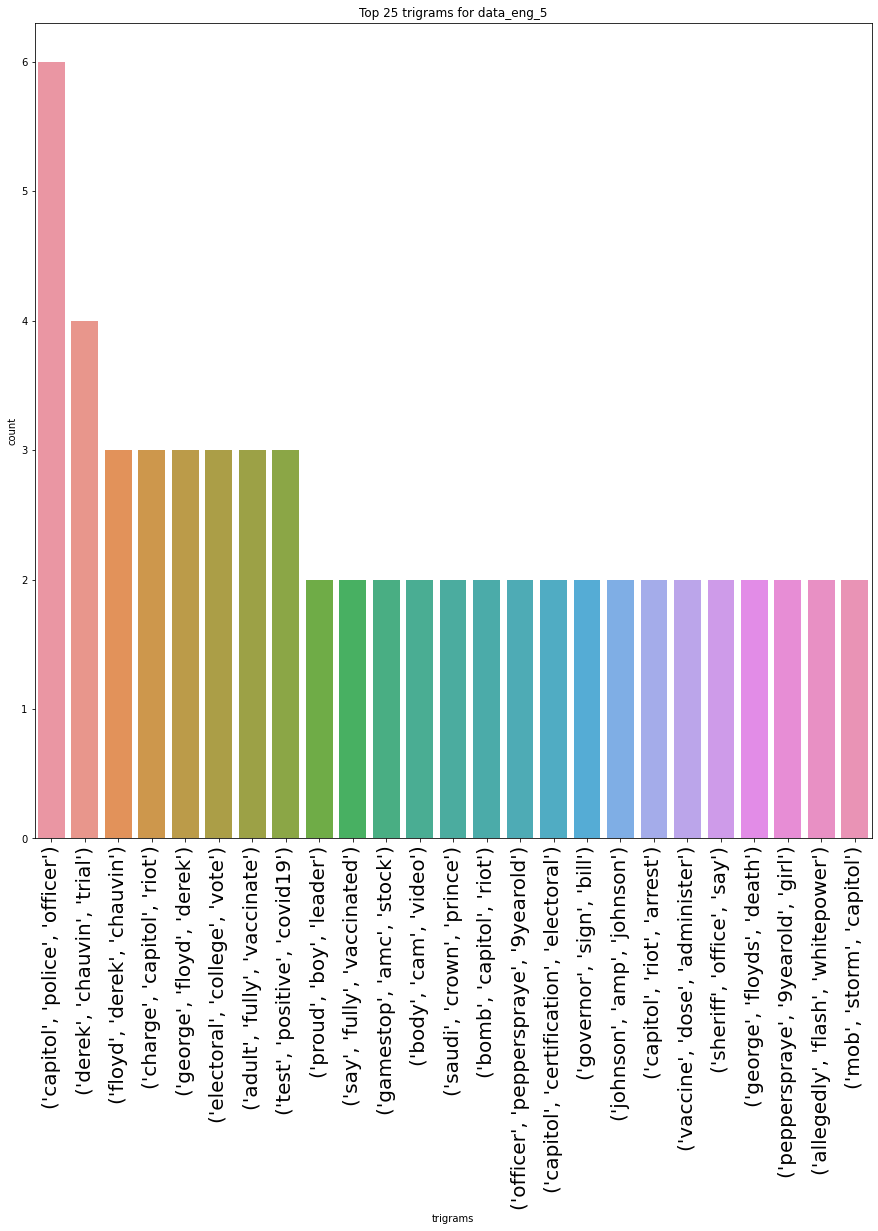

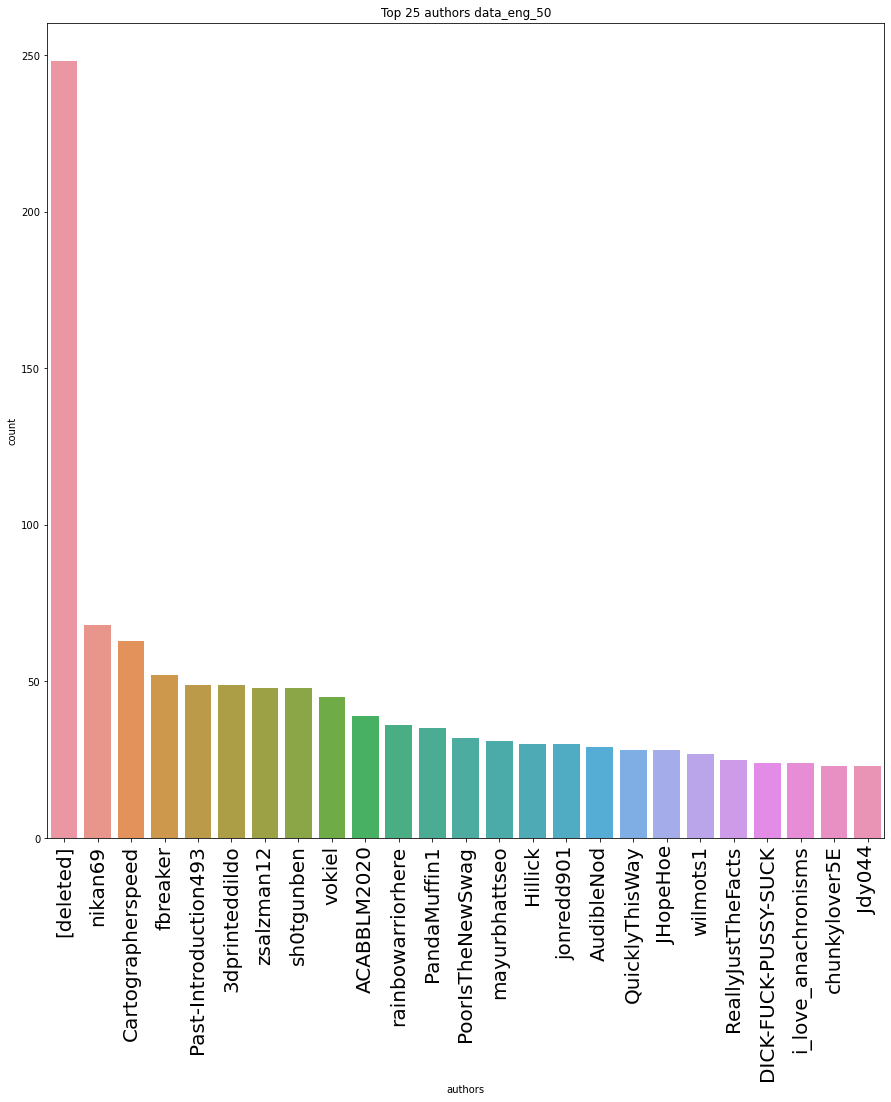

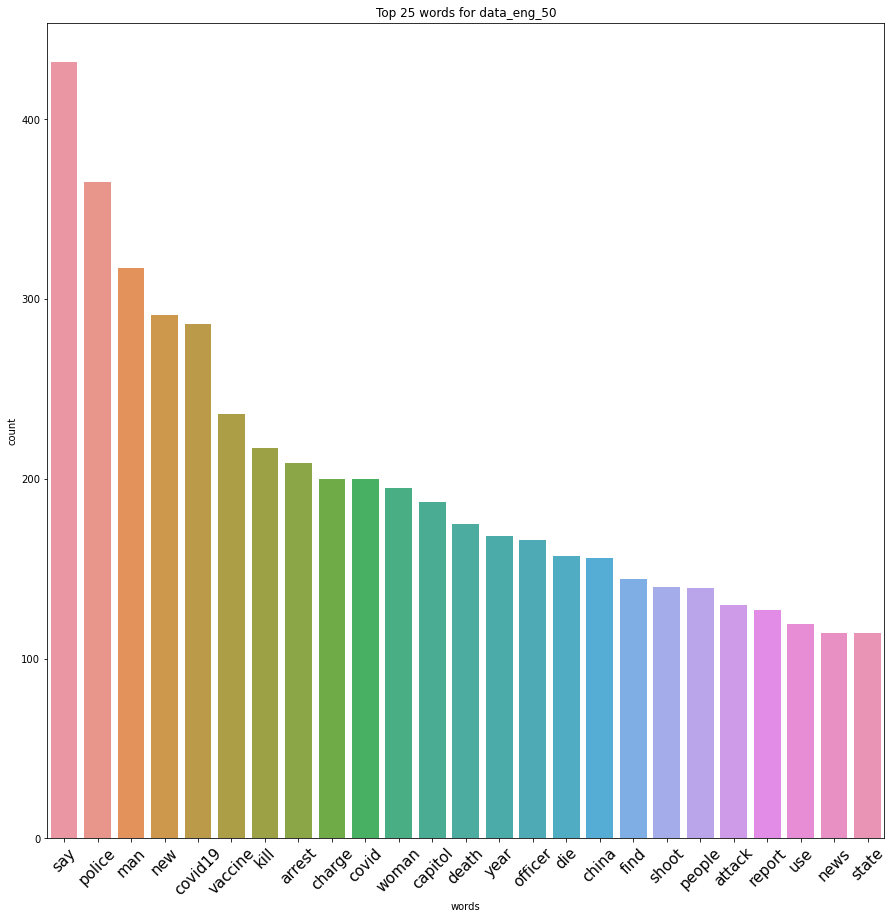

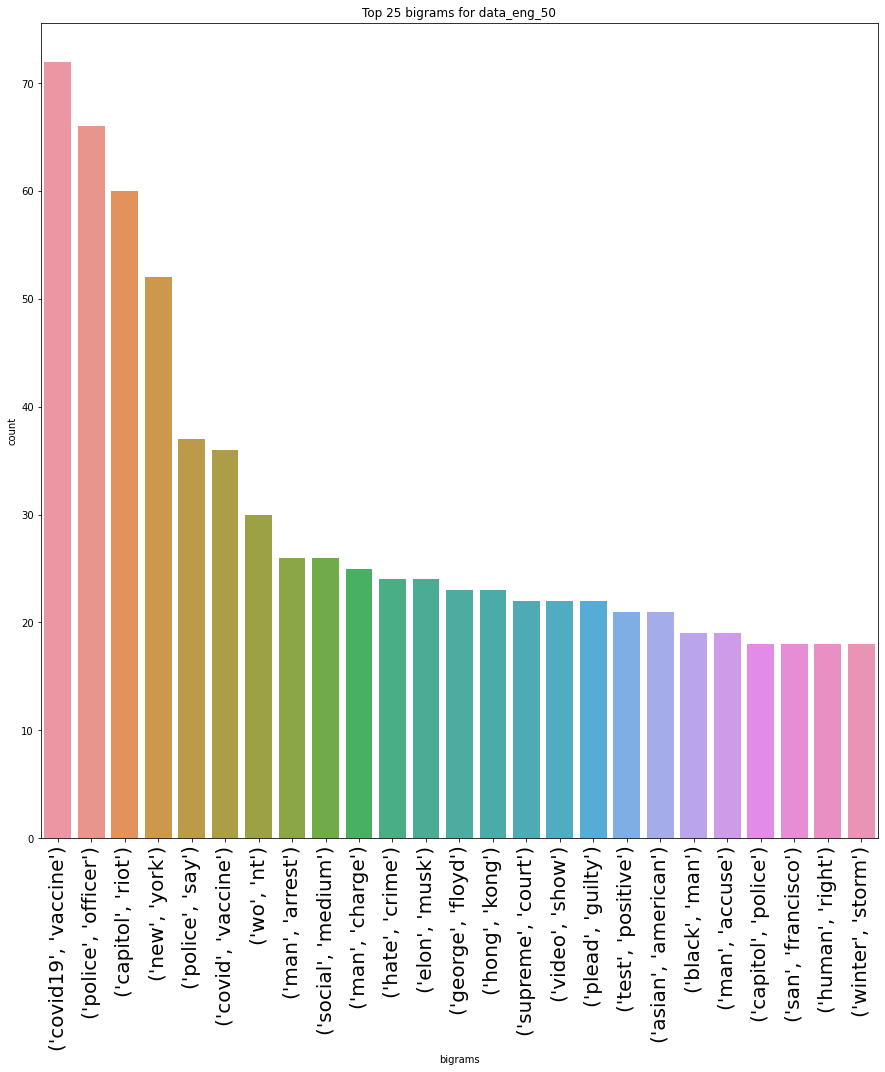

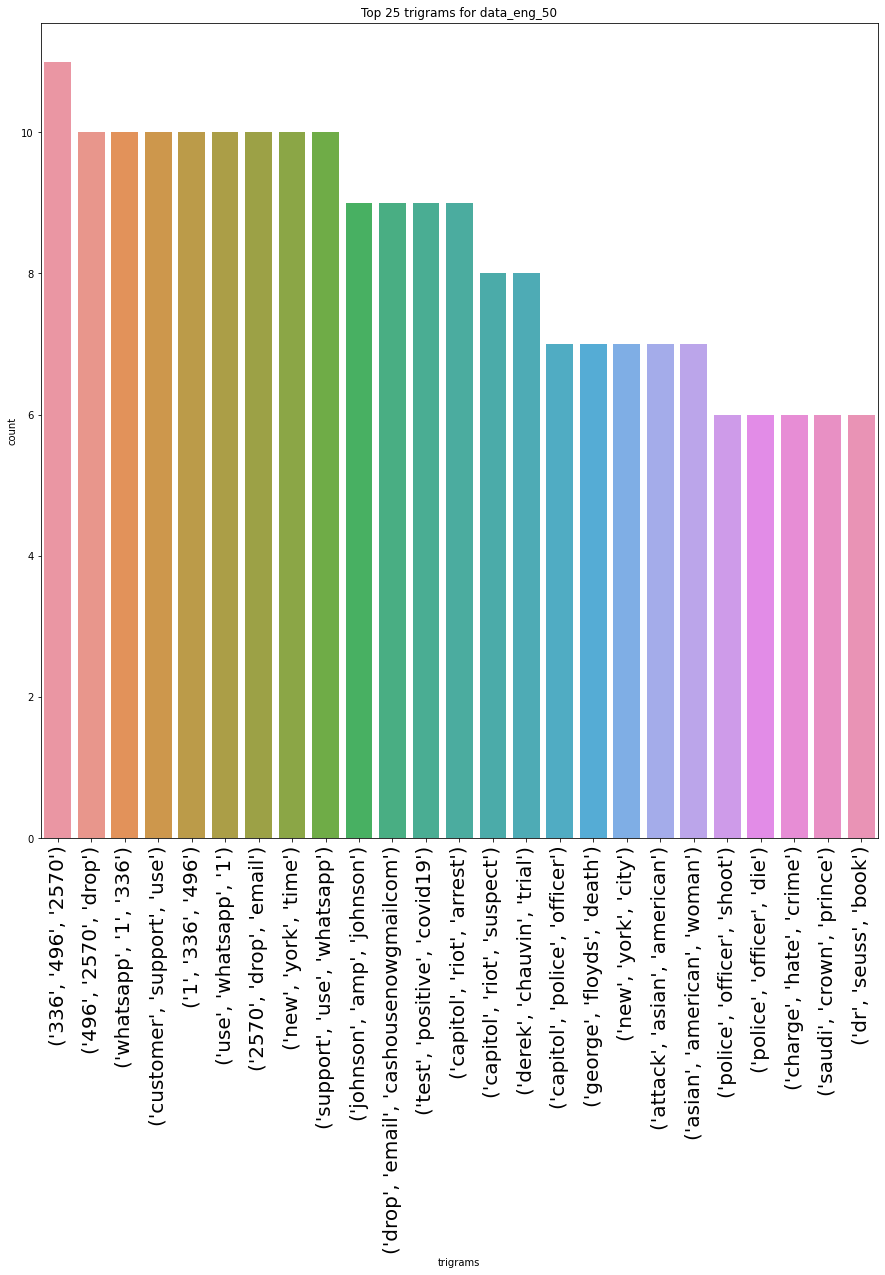

In [31]:
dfs = [data_analysis, data_eng_5, data_eng_50]

for df in dfs:
    name = df_name(df)
    


    authors_df = pd.DataFrame(df['Author'].value_counts())
    authors_df = authors_df.reset_index()
    authors_df.columns = ['authors','count']
    top_25_authors = authors_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
    plt.title("Top 25 authors " + str(name))
    plt.xticks(rotation=90, size=20)

    plt.show() 

    words = df['lemmatized_words'].explode()
    words_df = pd.DataFrame(words.value_counts())
    words_df = words_df.reset_index()
    words_df.columns = ['words','count']
    top_25_words = words_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
    plt.title("Top 25 words for " + str(name))
    plt.xticks(rotation=45, size=15)
    plt.show()

    bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
    bigrams_df = pd.DataFrame(bigrams)
    bigrams_df = bigrams_df.reset_index()
    bigrams_df.columns = ['bigrams','count']
    top_25_bigrams = bigrams_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
    plt.title("Top 25 bigrams for " + str(name))
    plt.xticks(rotation=90, size=20)
    plt.show()

    trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
    trigrams_df = pd.DataFrame(trigrams)
    trigrams_df = trigrams_df.reset_index()
    trigrams_df.columns = ['trigrams','count']
    top_25_trigrams = trigrams_df.head(25)

    plt.figure(figsize=(15,15))
    sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
    plt.title("Top 25 trigrams for " + str(name))
    plt.xticks(rotation=90, size=20)
    plt.show()

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=5)
tfidf_features = tfidf.fit_transform(data_analysis['lemmatized'])

In [34]:
tfidf_vect_df = pd.DataFrame(tfidf_features.todense(), columns = tfidf.get_feature_names())
data_analysis_tfidf = pd.concat([data_analysis, tfidf_vect_df], axis=1)
data_analysis_tfidf = data_analysis_tfidf.drop(['lemmatized'], axis=1)
data_analysis_tfidf = data_analysis_tfidf.drop(['Post ID', 'Title', 'Url', 'Author', 'Score', 'Publish Date',
       'Total No. of Comments', 'Permalink', 'Flair', 'duplicate',
       'Engagement', 'title_case_correct', 'title_words', 'language', 'lemmatized_words', 'score_percentile',
       'comments_percentile', 'engagement_percentile', 'score_band',
       'comm_band'], axis=1)
data_analysis_tfidf

eng_band   10  10 year  100  100 million  1000  10000        11   12  \
0            1  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
1            1  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
2            1  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
3            1  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
4            1  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
...        ...  ...      ...  ...          ...   ...    ...       ...  ...   
5935         0  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
5936         0  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
5937         0  0.0      0.0  0.0          0.0   0.0    0.0  0.494147  0.0   
5938         0  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   
5939         0  0.0      0.0  0.0          0.0   0.0    0.0  0.000000  0.0   

       13  ...  york city  york time  young  youth  youtube  zealand  zero  \
0     0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
1     0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
2     0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
3     0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
4     0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
...   ...  ...        ...        ...    ...    ...      ...      ...   ...   
5935  0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
5936  0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
5937  0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
5938  0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   
5939  0.0  ...        0.0        0.0    0.0    0.0      0.0      0.0   0.0   

      zone  zoo  zoom  
0      0.0  0.0   0.0  
1      0.0  0.0   0.0  
2      0.0  0.0   0.0  
3      0.0  0.0   0.0  
4      0.0  0.0   0.0  
...    ...  ...   ...  
5935   0.0  0.0   0.0  
5936   0.0  0.0   0.0  
5937   0.0  0.0   0.0  
5938   0.0  0.0   0.0  
5939   0.0  0.0   0.0  

[5940 rows x 2523 columns]

In [35]:
cv = CountVectorizer(ngram_range=(1,3), stop_words='english', min_df=5)
cv_features = cv.fit_transform(data_analysis['lemmatized'])

In [36]:
cv_vect_df = pd.DataFrame(cv_features.todense(), columns = cv.get_feature_names())
data_analysis_cv = pd.concat([data_analysis, cv_vect_df], axis=1)
data_analysis_cv = data_analysis_cv.drop(['lemmatized'], axis=1)
data_analysis_cv = data_analysis_cv.drop(['Post ID', 'Title', 'Url', 'Author', 'Score', 'Publish Date',
       'Total No. of Comments', 'Permalink', 'Flair', 'duplicate',
       'Engagement', 'title_case_correct', 'title_words', 'language', 'lemmatized_words', 'score_percentile',
       'comments_percentile', 'engagement_percentile', 'score_band',
       'comm_band'], axis=1)
data_analysis_cv

eng_band  10  10 year  100  100 million  1000  10000  11  12  13  ...  \
0            1   0        0    0            0     0      0   0   0   0  ...   
1            1   0        0    0            0     0      0   0   0   0  ...   
2            1   0        0    0            0     0      0   0   0   0  ...   
3            1   0        0    0            0     0      0   0   0   0  ...   
4            1   0        0    0            0     0      0   0   0   0  ...   
...        ...  ..      ...  ...          ...   ...    ...  ..  ..  ..  ...   
5935         0   0        0    0            0     0      0   0   0   0  ...   
5936         0   0        0    0            0     0      0   0   0   0  ...   
5937         0   0        0    0            0     0      0   1   0   0  ...   
5938         0   0        0    0            0     0      0   0   0   0  ...   
5939         0   0        0    0            0     0      0   0   0   0  ...   

      york city  york time  young  youth  youtube  zealand  zero  zone  zoo  \
0             0          0      0      0        0        0     0     0    0   
1             0          0      0      0        0        0     0     0    0   
2             0          0      0      0        0        0     0     0    0   
3             0          0      0      0        0        0     0     0    0   
4             0          0      0      0        0        0     0     0    0   
...         ...        ...    ...    ...      ...      ...   ...   ...  ...   
5935          0          0      0      0        0        0     0     0    0   
5936          0          0      0      0        0        0     0     0    0   
5937          0          0      0      0        0        0     0     0    0   
5938          0          0      0      0        0        0     0     0    0   
5939          0          0      0      0        0        0     0     0    0   

      zoom  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
5935     0  
5936     0  
5937     0  
5938     0  
5939     0  

[5940 rows x 2523 columns]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#importing our models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [38]:
#dv = data_analysis_tfidf.eng_band
#ivs = data_analysis_tfidf.drop(['eng_band'], axis=1)

#X_train, X_test, y_train, y_test = train_test_split(ivs, dv, test_size=.2, random_state=8)

In [39]:
#log_reg = LogisticRegression(max_iter=5000)

#C_val = [.0001, .001, .01, .1, 1, 10, 100]
#pen = ['l2']

#param_grid = dict(C = C_val, penalty = pen)

In [40]:
#grid_tfidf = GridSearchCV(log_reg, param_grid= param_grid, cv = 10, scoring = 'roc_auc')

In [41]:
#grid_tfidf.fit(X_train, y_train)

In [42]:
#print(grid_tfidf.best_score_)
#print(grid_tfidf.best_params_)

In [43]:
#log_reg_tfidf_pred = grid_tfidf.predict(X_test)
#print(roc_auc_score(y_test, log_reg_tfidf_pred))
#print(classification_report(y_test, log_reg_tfidf_pred))

In [44]:
dv_2 = data_analysis_cv.eng_band
ivs_2 = data_analysis_cv.drop(['eng_band'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(ivs_2, dv_2, test_size=.2, random_state=8)

In [45]:
#log_reg = LogisticRegression(max_iter=5000)

#C_val = [.0001, .001, .01, .1, 1, 10, 100]
#pen = ['l2']

#param_grid = dict(C = C_val, penalty = pen)

In [46]:
#grid_tfidf = GridSearchCV(log_reg, param_grid= param_grid, cv = 10, scoring = 'roc_auc')

In [47]:
#grid_tfidf.fit(X_train, y_train)

In [48]:
#print(grid_tfidf.best_score_)
#print(grid_tfidf.best_params_)

In [49]:
#log_reg_tfidf_pred = grid_tfidf.predict(X_test)
#print(roc_auc_score(y_test, log_reg_tfidf_pred))
#print(classification_report(y_test, log_reg_tfidf_pred))

In [50]:
log_reg = LogisticRegression(C = .1, penalty = 'l2', max_iter=5000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)[:,1]

In [51]:
from sklearn.metrics import roc_curve, auc

log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred)
log_auc_score = auc(log_fpr, log_tpr)
print(log_auc_score)

0.6630453736965088


In [52]:
# knn

knn = KNeighborsClassifier()

k_range = list(np.arange(2,23,2))
knn_params = dict(n_neighbors=k_range)

In [53]:
#grid = GridSearchCV(knn, param_grid=knn_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [54]:
knn = KNeighborsClassifier(n_neighbors = 22)
knn.fit(X_train, y_train)
y_pred = knn.predict_proba(X_test)[:,1]

In [55]:
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred)
knn_auc_score = auc(knn_fpr, knn_tpr)
print(knn_auc_score)

0.5698479405712692


In [56]:
# svc

svc = SVC()

svc_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  }

In [57]:
#grid = GridSearchCV(svc, svc_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [58]:
svc = SVC(C=1, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict_proba(X_test)[:,1]

In [59]:
svc_fpr, svc_tpr, threshold = roc_curve(y_test, y_pred)
svc_auc_score = auc(svc_fpr, svc_tpr)
print(svc_auc_score)

0.6639695881142538


In [60]:
# rf

rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : [2,3,4,5,6],
}

In [61]:
#grid = GridSearchCV(rf, rf_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [62]:
rf = RandomForestClassifier(max_depth= 6, max_features= 'auto',n_estimators= 100)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]

In [63]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred)
rf_auc_score = auc(rf_fpr, rf_tpr)
print(rf_auc_score)

0.6201042792871343


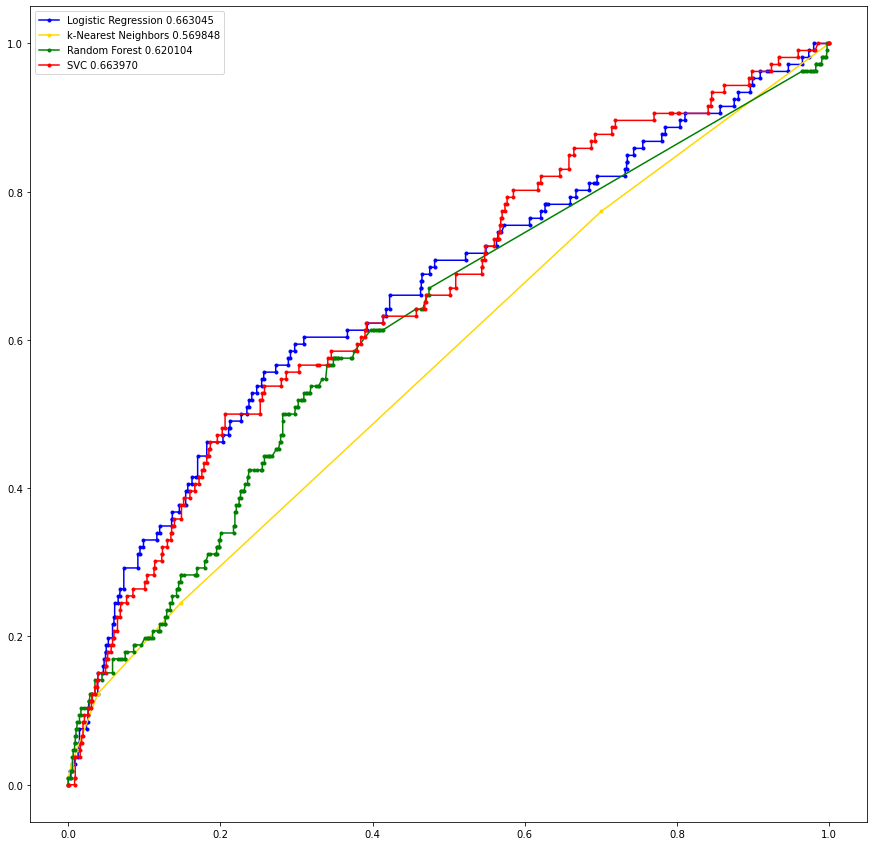

In [64]:
fig, heat = plt.subplots(figsize = (15,15))
plt.plot(log_fpr, log_tpr, marker='.', color='blue', label='Logistic Regression %f' % log_auc_score)
plt.plot(knn_fpr, knn_tpr, marker='.', color='gold', label='k-Nearest Neighbors %f' % knn_auc_score)
plt.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest %f' % rf_auc_score)
plt.plot(svc_fpr, svc_tpr, marker='.', color='red', label='SVC %f' % svc_auc_score)

plt.legend()
plt.savefig('r_news_aucs.png')
plt.show()

In [65]:
feature_names = data_analysis_cv.drop(['eng_band'], axis=1).columns
feature_names = list(feature_names)
feature_names

['10',
 '10 year',
 '100',
 '100 million',
 '1000',
 '10000',
 '11',
 '12',
 '13',
 '13yearold',
 '14',
 '14yearold',
 '15',
 '15 year',
 '150',
 '15000',
 '16',
 '16yearold',
 '18',
 '19',
 '1st',
 '20',
 '20 year',
 '200',
 '2019',
 '2020',
 '2021',
 '2022',
 '22',
 '23',
 '24',
 '25',
 '2570',
 '2570 drop',
 '2570 drop email',
 '26',
 '27',
 '27 billion',
 '27 year',
 '29',
 '2nd',
 '30',
 '30 year',
 '3000',
 '32',
 '336',
 '336 496',
 '336 496 2570',
 '3yearold',
 '40',
 '400',
 '4000',
 '400000',
 '41',
 '44',
 '45',
 '48',
 '496',
 '496 2570',
 '496 2570 drop',
 '4yearold',
 '50',
 '50 state',
 '500',
 '500000',
 '5yearold',
 '60',
 '600',
 '65',
 '70',
 '700',
 '737',
 '777',
 '78',
 '80',
 '81',
 '90',
 '91',
 '911',
 '99',
 '9yearold',
 'abandon',
 'able',
 'abortion',
 'abram',
 'abuse',
 'accept',
 'access',
 'accidentally',
 'accord',
 'account',
 'accuse',
 'accuse kill',
 'act',
 'action',
 'active',
 'activist',
 'actor',
 'actress',
 'actually',
 'ad',
 'add',
 'addres

In [66]:
importance = log_reg.coef_[0]

In [67]:
importance = list(np.round(importance, decimals=5))

In [68]:
features_dict = {'feature':feature_names, 'importance': importance}

Feature: 0, Score: -0.10679
Feature: 1, Score: 0.05442
Feature: 2, Score: 0.34103
Feature: 3, Score: 0.17441
Feature: 4, Score: -0.04129
Feature: 5, Score: 0.14289
Feature: 6, Score: 0.05499
Feature: 7, Score: 0.12058
Feature: 8, Score: 0.04337
Feature: 9, Score: 0.00803
Feature: 10, Score: 0.08482
Feature: 11, Score: 0.03640
Feature: 12, Score: 0.10005
Feature: 13, Score: 0.03425
Feature: 14, Score: 0.14385
Feature: 15, Score: 0.13283
Feature: 16, Score: 0.03787
Feature: 17, Score: 0.06404
Feature: 18, Score: -0.10813
Feature: 19, Score: -0.00357
Feature: 20, Score: 0.04109
Feature: 21, Score: 0.01339
Feature: 22, Score: 0.03143
Feature: 23, Score: -0.05625
Feature: 24, Score: -0.04071
Feature: 25, Score: -0.12072
Feature: 26, Score: -0.12988
Feature: 27, Score: 0.05506
Feature: 28, Score: 0.03800
Feature: 29, Score: 0.05093
Feature: 30, Score: -0.05670
Feature: 31, Score: 0.02316
Feature: 32, Score: -0.03527
Feature: 33, Score: -0.03527
Feature: 34, Score: -0.03527
Feature: 35, Score

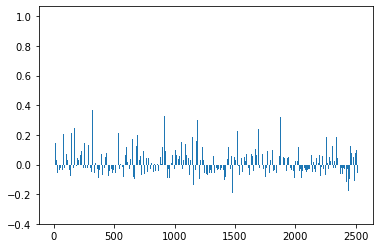

In [69]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [70]:
feature_importances = pd.DataFrame(features_dict)
feature_importances.sort_values(by='importance', ascending=False).head(50)

feature  importance
2331           trump     1.00103
396          capitol     0.87068
2266           texas     0.51770
298            biden     0.51537
1585         officer     0.48630
889              fbi     0.43690
1114            hour     0.41609
2161            stop     0.40643
1460          minute     0.38286
2008            sell     0.37102
320            block     0.36622
1244           judge     0.36565
1393            mask     0.36039
330             bomb     0.34430
2                100     0.34103
653               dc     0.33339
2162           store     0.33092
917             fine     0.33027
106            adult     0.32332
1878          remove     0.32182
526         colorado     0.32179
1416      megathread     0.31817
1042             gun     0.31193
1698            pipe     0.30769
1190   investigation     0.29855
325             body     0.29295
344          boycott     0.29067
962           freeze     0.27941
1809        protrump     0.27876
1100            home     0.27805
2487            wood     0.27338
141        allegedly     0.27269
1002         georgia     0.27262
1523            navy     0.27242
264              ban     0.27106
1529            neck     0.26766
785           effort     0.26355
1927          rioter     0.26296
451           charge     0.26178
2009          senate     0.26062
659            death     0.25509
1597        official     0.25486
1867          refuse     0.25047
171         announce     0.24949
1775          prison     0.24617
2238          taylor     0.24520
452   charge capitol     0.24304
1696           pilot     0.24222
2489          worker     0.24216
469            check     0.24089

In [71]:
feature_importances_ngram = pd.DataFrame(features_dict)
feature_importances_ngram['ngram'] = feature_importances_ngram['feature'].str.contains(' ')
feature_importances_ngram = feature_importances_ngram[feature_importances_ngram.ngram]
feature_importances_ngram.sort_values(by='importance', ascending=False).head(50)

feature  importance  ngram
452        charge capitol     0.24304   True
402          capitol riot     0.23829   True
405        capitol rioter     0.23714   True
1699            pipe bomb     0.22656   True
1006    ghislaine maxwell     0.21940   True
2165        storm capitol     0.21273   True
299    biden inauguration     0.21065   True
1733      police shooting     0.20776   True
693   derek chauvin trial     0.19628   True
354        breonna taylor     0.18822   True
2510          year prison     0.18724   True
1726       police officer     0.18674   True
468         chauvin trial     0.18610   True
473        chicago police     0.18609   True
692         derek chauvin     0.18483   True
326           body camera     0.17641   True
3             100 million     0.17441   True
1811            proud boy     0.16614   True
2260        test positive     0.16463   True
1294     kyle rittenhouse     0.15235   True
982          gamestop amc     0.14481   True
1922          right group     0.14317   True
1424        mental health     0.14190   True
476            child porn     0.13906   True
527       colorado spring     0.13695   True
2490           worker die     0.13598   True
1516       national guard     0.13149   True
2285           tiger wood     0.13091   True
2436     washington state     0.12908   True
157         amid gamestop     0.12896   True
999          george floyd     0.12752   True
1023        governor sign     0.12324   True
602   covid19 vaccination     0.12060   True
1255        kamala harris     0.11763   True
591           covid death     0.11675   True
2027      sex trafficking     0.11673   True
2381         vaccine dose     0.11666   True
1447        militia group     0.11574   True
900         federal judge     0.11525   True
315            black teen     0.11513   True
1749     positive covid19     0.11383   True
2467          white house     0.10670   True
2407         virginia man     0.10587   True
1671          people kill     0.10552   True
1666       pelosis office     0.10104   True
2508             year ago     0.09971   True
444               ceo say     0.09963   True
1812     proud boy leader     0.09826   True
343            boy leader     0.09826   True
1087          high school     0.09806   True

In [ ]:
# label and try to remove specific high-engagement stories
# downsample labeled stories
# Named entity recognition in spacy
# Percentage of top stories are "major" stories
# proof of concept, limited by IVs
# next steps: story/body text, more data (decades)
# present call, pause, final call, done
# word embedding/raw words labelling for general labels
